# TextRank + ROUGE

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import networkx as nx
from rouge import Rouge
from tqdm import tqdm_notebook
import time
import os.path
from datetime import datetime
import re

### Build dataset

In [3]:
dtypes_br = {
    'match_id': 'int64',
    'team1': 'object',
    'team2': 'object',
    'name': 'object',
    'match_time': 'int64',
    'type': 'category',
    'minute': 'int64',
    'content': 'object',
    'message_time':'int64'
}
broadcasts = pd.read_csv('data/ods_broadcasts_201905301157.csv',
                 header=0, 
                 usecols=dtypes_br.keys(), 
                 skipinitialspace=True,
                 skip_blank_lines=True,
                 encoding='utf-8')
broadcasts.content.apply(str)
dtypes_ns = {
    'id': 'int64',
    'name': 'object',
    'ctime': 'int64',
    'body': 'object',
    'match_id': 'int64',
}
news = pd.read_csv('data/ods_match_news.csv',
                 header=0, 
                 usecols=dtypes_ns.keys(), 
                 skipinitialspace=True,
                 skip_blank_lines=True,
                 encoding='utf-8')

In [4]:
len(news.match_id.unique())

7671

In [5]:
def time_type_news(one_news, one_broadcasts):
    assert type(one_news) == pd.core.series.Series, "one_news should be Series"
    assert type(one_broadcasts) == pd.core.series.Series, "one_news should be Series"
    before = 'before'
    after = 'after'
    time_match = datetime.fromtimestamp(one_broadcasts.match_time)
    time_news  = datetime.strptime(one_news.ctime, "%Y-%m-%d %H:%M:%S")
    #print(time_match, "-", time_news, before if time_news < time_match else after)
    return before if time_news < time_match else after

In [6]:
before = []
after = []
for match_id in news.match_id.unique():
    one_broadcast = broadcasts[broadcasts['match_id']==match_id].iloc[0]
    news_scope = news[news.match_id==match_id]
    one_result = {'after':0, 'before':0}
    for i in range(len(news_scope)):
        cur_news = news_scope.iloc[i]
        ttn = time_type_news(cur_news, one_broadcast)
        one_result[ttn] += 1
    before.append(one_result['before'])
    after.append(one_result['after'])

In [7]:
assert len(before)==len(after)

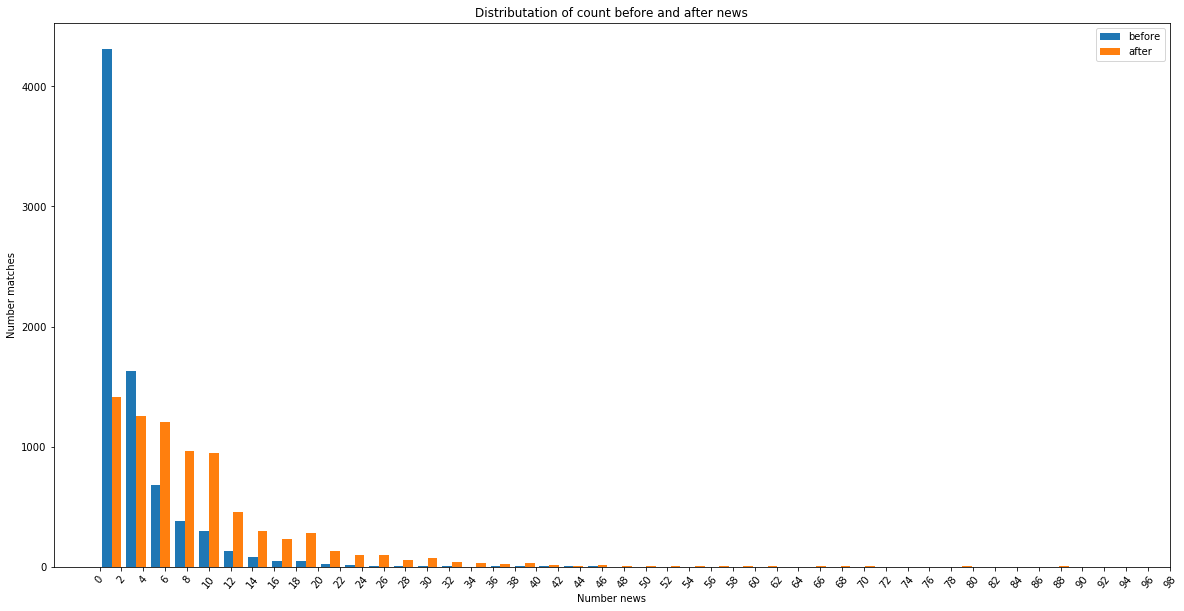

In [8]:
plt.figure(figsize=(20,10))
plt.hist([before,after],label=['before', 'after'], bins=40)
plt.legend(prop={'size': 10})
plt.title("Distributation of count before and after news")
plt.xlabel("Number news")
plt.ylabel("Number matches")
plt.xticks(range(0,100,2), rotation=50);

In [10]:
news.match_id.unique()[0:100]

array([18936, 18935, 18941, 18956, 18957, 19236, 19222, 19227, 18925,
       19104, 19105, 19235, 19231, 19108, 19107, 19109, 19113, 19111,
       19114, 19112, 19115, 19116, 19117, 19122, 19120, 19119, 19121,
       19644, 19647, 19123, 19125, 19124, 19126, 19127, 19129, 19128,
       19130, 19654, 19653, 19132, 19131, 19133, 19134, 19137, 19135,
       19136, 19138, 19675, 19142, 19139, 19140, 19143, 19144, 19145,
       19146, 19682, 19683, 19671, 19699, 19147, 19150, 19705, 19148,
       19153, 19154, 19707, 19152, 19151, 19725, 19723, 19724, 19738,
       19157, 19155, 19746, 19156, 19161, 19747, 19162, 19160, 19159,
       19757, 19163, 19164, 19165, 19166, 19170, 19764, 19168, 19169,
       19167, 19765, 19763, 19174, 19172, 19173, 19171, 19177, 19178,
       19176])

In [17]:
def clean_news_text(text):
    return  re.sub("(&#(?:\d)*;)", "", re.sub("<.*?>", "", text)).replace("\n","").replace("\r","").replace("\x96","")

In [21]:
match_id=19683
news_scope = news[news.match_id==match_id]
one_broadcast = broadcasts[broadcasts['match_id']==match_id].iloc[0]
for i in range(len(news_scope)):
        cur_news = news_scope.iloc[i]
        ttn = time_type_news(cur_news, one_broadcast)
        print("====",ttn,"=====")
        print(clean_news_text(cur_news.body))

==== before =====
Сегодня Sports.ru продолжит текстовые трансляции чемпионата мира-2009. За всеми значимыми событиями (голы, броски, удаления и т.д.) всех матчей дня вы сможете следить на странице онлайна, обмениваясь по ходу впечатлениями в матч-чате.При этом для матча Россия  Швейцария предусмотрена подробная текстовая трансляция. Начало онлайна  в 17.30 по московскому времени.
==== before =====
Главный тренер сборной России Вячеслав Быков оценил конкуренцию среди вратарей, объяснил, с чем связана эпидемия травм, а также рассказал о Швейцарии, с которой нашей команде предстоит сыграть в третьем матче группового этапа ЧМ-2009.Против Швейцарии будет играть Брызгалов. Выйдет ли Еременко на лед еще? У нас заявлены два вратаря. По ситуации примем решение по третьему голкиперу. Я пока не могу ничего обещать. Посмотрим по ходу турнира. Этот чемпионат состоит не из 20 матчей. Он может получиться скоротечным. Нужно быть внимательным и осторожным.Вариант с приглашением вратарей из НХЛ не исклю